In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Fig4 b

In [2]:
temporal_portion = pd.read_csv(f'../data/fig4/cross_barrier_temporal_HOUR_OF_DAY_2019.csv')
temporal_portion['HOUR_OF_DAY'] = temporal_portion['HOUR_OF_DAY'].astype(int)
# if temporal_portion['HOUR_OF_DAY'] == 0, change to 24
temporal_portion.loc[temporal_portion['HOUR_OF_DAY'] == 0, 'HOUR_OF_DAY'] = 24

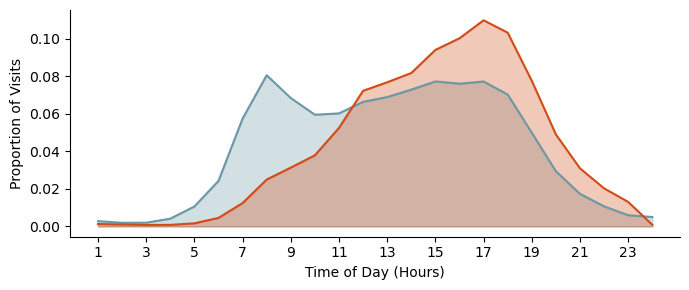

In [3]:
act_portion = temporal_portion.sort_values(by='HOUR_OF_DAY').reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(
    act_portion['HOUR_OF_DAY'], act_portion['non_barrier_visit_portion'],
    label='Non-barrier Visits', linewidth=1.5, color='#6a98a5', fillstyle='full'
)
ax.fill_between(
        act_portion['HOUR_OF_DAY'], 
        act_portion['non_barrier_visit_portion'],
        alpha=0.3,
        color='#6a98a5'
)

ax.plot(
    act_portion['HOUR_OF_DAY'], act_portion['barrier_visit_portion'], 
    label='Barrier Visits', linewidth=1.5, color='#d24c18', fillstyle='full'
)
ax.fill_between(
    act_portion['HOUR_OF_DAY'], 
    act_portion['barrier_visit_portion'],
    alpha=0.3,
    color='#d24c18'
)

sns.despine() # top=True, right=True, bottom=True, left=True
ax.set_xticks(range(1, 24, 2))  # Set x ticks every 2 hours
ax.set_xticklabels(range(1, 24, 2))  # Set x tick labels , fontdict={'fontsize':16}
ax.set_xlabel('Time of Day (Hours)')
ax.set_ylabel('Proportion of Visits')

fig.tight_layout()
plt.savefig(f'../outputs/fig4_b.pdf', bbox_inches='tight', dpi=300)

## Fig4 c

In [4]:
def cal_area_portion(year_df):
    # unimportant categories to remove for visual clarity
    cat2rm = ['Agriculture', 'Health', 'School', 'Arts / Museum', 'Neighborhood Service', \
          'Public Administration', 'Personal Care Service', 'Automotive Service', 'Financial Service'] 

    all_portion = []    
    for area_code, local_df in year_df.groupby('area_code'):
        local_df = local_df[~local_df['taxonomy'].isin(cat2rm)].copy()
        local_df['barrier_visit_portion'] = local_df['barrier_visit_size'] / local_df['barrier_visit_size'].sum()
        local_df['non_barrier_visit_portion'] = local_df['non_barrier_visit_size'] / local_df['non_barrier_visit_size'].sum()
        local_df['barrier_visits_relative_difference'] = (local_df['barrier_visit_portion'] - local_df['non_barrier_visit_portion']) / local_df['non_barrier_visit_portion']
        local_df.fillna(0)
        local_df['area_code'] = area_code
        all_portion.append(local_df)
    return pd.concat(all_portion, axis=0)

In [5]:
activity_portion = pd.read_csv(f'../data/fig4/cross_barrier_activity_portion_2019.csv')
activity_portion = cal_area_portion(activity_portion)
activity_portion = activity_portion.replace({'taxonomy': {'School': 'Professional School', 'Health': 'Veterinary Services'}})

null_diff_distribution = pd.read_csv(f'../data/fig4/cross_barrier_activity_portion_null_stats_2019.csv')[['taxonomy', 'confidence_interval']]
null_diff_distribution = null_diff_distribution.replace({'taxonomy': {'School': 'Professional School', 'Health': 'Veterinary Services'}})


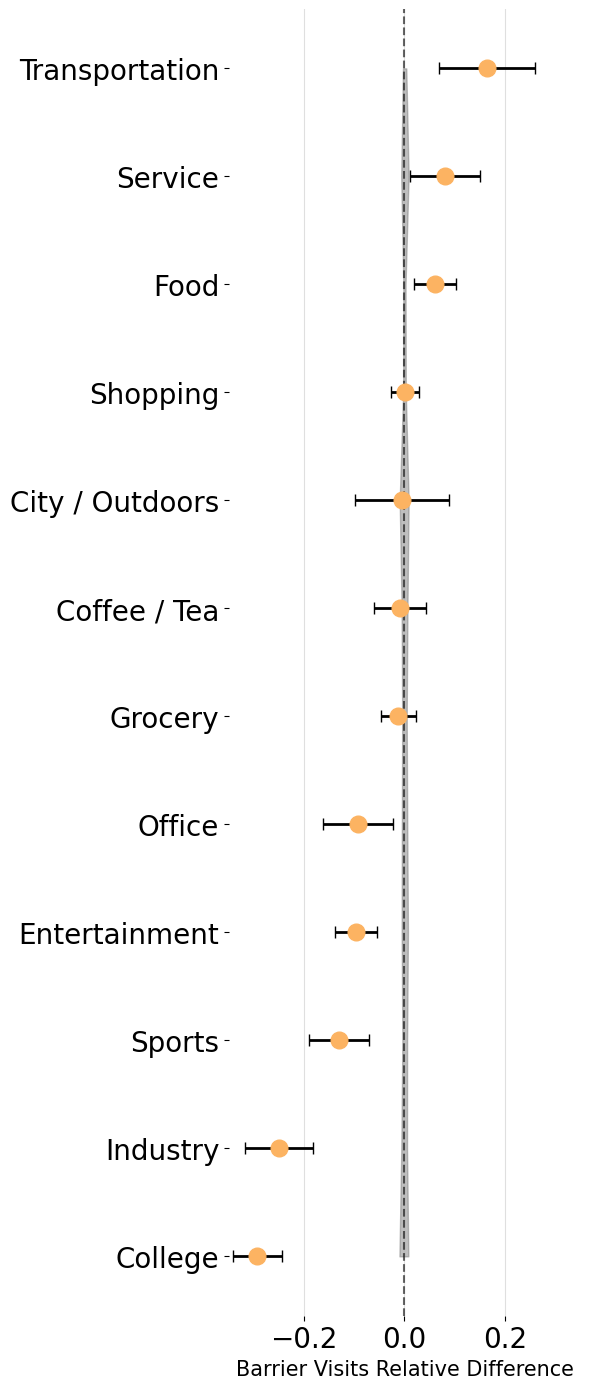

In [6]:
marker_color = '#fcb362'
scatter_size = 400
plt.figure(figsize=(6, 14))  # Swapped width and height

year_data = activity_portion
tax_order_df = year_data.groupby('taxonomy')['barrier_visits_relative_difference'].mean().sort_values(ascending=True).reset_index(name='mean_barrier_visits_relative_difference')
tax_order = tax_order_df['taxonomy'].to_list()

# Calculate means and 95% confidence intervals for each taxonomy
from scipy import stats
means = []
ci_lower = []
ci_upper = []

for tax in tax_order:
    tax_data = year_data[year_data['taxonomy'] == tax]['barrier_visits_relative_difference']
    mean_val = tax_data.mean()
    std_err = stats.sem(tax_data)  # Standard error of the mean
    ci = stats.t.interval(0.95, len(tax_data)-1, loc=mean_val, scale=std_err)
    
    means.append(mean_val)
    ci_lower.append(mean_val - ci[0])
    ci_upper.append(ci[1] - mean_val)

# Get confidence intervals for each taxonomy, Plot confidence intervals using fill_between
confidence_intervals = null_diff_distribution
upper_bound = []
lower_bound = []
for i, tax in enumerate(tax_order):
    tax_ci = confidence_intervals[confidence_intervals['taxonomy'] == tax]['confidence_interval'].iloc[0].split(',')
    upper_bound.append(float(tax_ci[1][1:-1]))
    lower_bound.append(float(tax_ci[0][1:]))
plt.fill_betweenx(  # Changed to fill_betweenx for vertical layout
    y = np.array(range(len(tax_order))),
    x1 = np.array(upper_bound),
    x2 = np.array(lower_bound),
    color = 'grey',
    alpha=0.5
)

# Replace sns.pointplot with plt.errorbar
plt.errorbar(
    x=means,
    y=np.arange(len(tax_order)),
    xerr=[ci_lower, ci_upper],  # Error bars for 95% CI
    fmt='o',  # Marker style
    color=marker_color,
    ecolor='black',
    capsize=4,  # Cap size for error bars
    elinewidth=2,  # Error bar line width
    markersize=12  # Marker size
)

plt.grid(alpha=0.4, axis='x')  # Changed to axis='x'
plt.axvline(x=0, color='black', linestyle='--', alpha=0.6)  # Changed to axvline
plt.yticks(np.arange(len(tax_order)), tax_order)  # Changed to yticks
plt.ylabel('', fontsize=14)  # Swapped xlabel and ylabel
plt.xlabel('Barrier Visits Relative Difference', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.yticks(rotation=0, ha='right')  # Changed to yticks and rotation=0
plt.xlim([-0.35,0.35])  # Changed to xlim
sns.despine(top=True, right=True, left=True, bottom=True)

plt.tight_layout()

plt.savefig(f'../outputs/fig4_c.pdf', bbox_inches='tight', dpi=300)

## Fig4 d

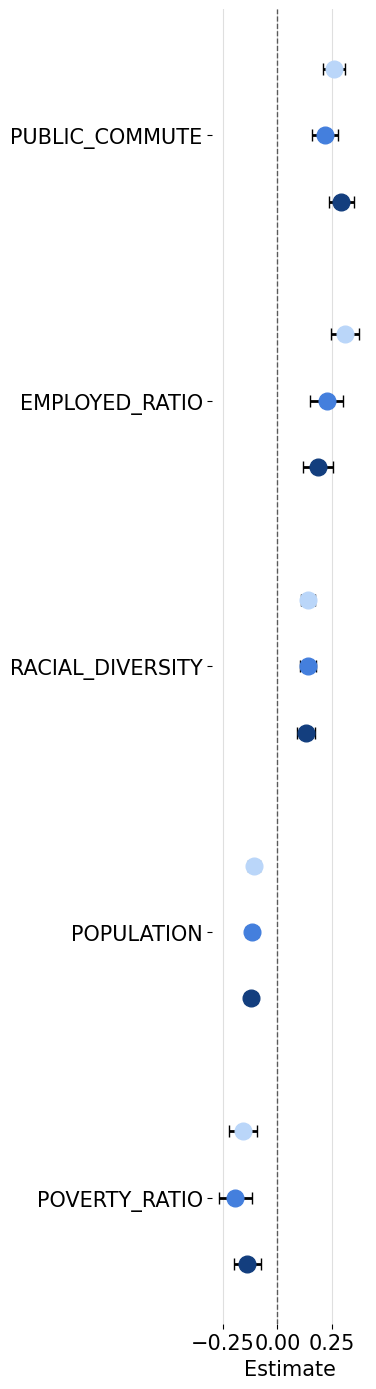

In [7]:
color_mapping = {
    2019: '#bad6f9',
    2020: '#447fdd',
    2021: '#133e7e',
}
all_model_estimates = []
for year in range(2019, 2022):
    model_estimates_path = f'../data/fig4/{year}_who_cross_barriers.csv'
    model_estimates = pd.read_csv(model_estimates_path)
    model_estimates['year'] = year
    model_estimates['color'] = model_estimates['year'].map(color_mapping)
    all_model_estimates.append(model_estimates)
all_model_estimates = pd.concat(all_model_estimates)

fig, ax = plt.subplots(figsize=(4, 14))
# fig.suptitle('suptitle', fontsize=25)

ax.set_xlabel('Estimate', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
# Order the y-axis by the average statistic of three years
term_order = all_model_estimates.groupby('term')['estimate'].mean().sort_values().index.tolist()
ax.set_yticks(range(len(term_order)))
ax.set_yticklabels(term_order)

# Add y-offset for each year to avoid overlapping error bars
year_offsets = {2019: 0.25, 2020: 0, 2021: -0.25}
for i, row in all_model_estimates.iterrows():
    y_pos = term_order.index(row['term']) + year_offsets[row['year']]
    ax.errorbar(row['estimate'], y_pos, xerr=row['std.error'], fmt='o', 
                color=row['color'], ecolor='black', elinewidth=2, 
                capsize=4, markersize=12)

# Add legend for different years
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                        markerfacecolor=color, markersize=12, 
                        label=f'{year}') 
                for year, color in color_mapping.items()]

# Draw vertical line at x=0 first, then get ylim after all elements are added
# This ensures the line spans the entire y-axis
ax.axvline(x=0, color='black', alpha=0.6, linewidth=1, linestyle='--')

ax.grid(alpha=0.4, axis='x')

sns.despine(top=True, right=True, bottom=True, left=True) 
plt.savefig(f'../outputs/fig4_d.pdf', bbox_inches='tight', dpi=300)
    
plt.tight_layout()
plt.show()